In [ ]:
# we need the following libraries, so let's install them
!pip install boto3
!pip install torchxrayvision
!pip install SimpleITK
!pip install radiomics
!pip install pyradiomics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing libraries
import boto3
import numpy as np
import pandas as pd
from glob import glob
import os
import skimage
import torchxrayvision as xrv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

In [ ]:
# checking for the avaialblity of any cuda-enabled processor
torch.cuda.is_available()

True

In [ ]:
# to see whether gpu is avaialbe  or not
!nvidia-smi   

Sun Apr  9 03:14:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# making directories to save images, labels 
path = os.getcwd()
name_of_folder = 'CheXpert'
path = path+'/sample_data' + '/' + name_of_folder
path_targets = path+'/'+'targets'
path_images = path+'/'+'images'
path_codes = path+'/'+'codes'

try:
  os.makedirs(path)
except:
  pass

try:
  os.makedirs(path_targets)
except:
  pass

try:
  os.makedirs(path_images + '/train')
  os.makedirs(path_images + '/valid')

except:
  pass

try:
  os.makedirs(path_codes)
except:
  pass


In [ ]:
# importing written classes and methods
import sys
sys.path.insert(1, path_codes)

In [ ]:
# connecting to the bucket of image data in S3
aws_access_key_id = '----------------------------'
aws_secret_access_key = '------------------------------'
region='us-east-1'
Bucket = 'um2ii-datasets'
s3 = boto3.client(service_name = 's3',
                    region_name = region,
                    aws_access_key_id = aws_access_key_id,
                    aws_secret_access_key = aws_secret_access_key)


In [ ]:
# downloading some chexpert data (labels with small sizes of images)
os.chdir(path_targets)
s3.download_file(Bucket=Bucket,Filename='metadata.csv',Key='CheXpert/CheXpert-small/metadata.csv')
s3.download_file(Bucket=Bucket,Filename='train.csv',Key='CheXpert/CheXpert-small/train.csv')
s3.download_file(Bucket=Bucket,Filename='valid.csv',Key='CheXpert/CheXpert-small/valid.csv')


In [ ]:
# visualizing the label
name = path_targets + '/metadata.csv'
data1 = pd.read_csv(name)
data1.head(1)

,Path,Patient_id,Study_Number,Sex,Age,Race,Ethnicity,Frontal/Lateral,AP/PA,No Finding,...,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0/train/patient00001/study1/view1_...,1,1,Female,68.0,Other,Non-Hispanic/Non-Latino,Frontal,AP,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# visualizing the label
name = path_targets + '/train.csv'
data = pd.read_csv(name)
data.head(1)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0


In [ ]:
all_files = list(data.iloc[:,0].values)
n_images = data.shape[0]
print(n_images)  # the size of images in chexpert datasets
print(all_files[0])

223414
CheXpert-v1.0/train/patient00001/study1/view1_frontal.jpg


In [ ]:
all_files[0:3] # just visualizing 3 names of images

['CheXpert-v1.0/train/patient00001/study1/view1_frontal.jpg',
 'CheXpert-v1.0/train/patient00002/study2/view1_frontal.jpg',
 'CheXpert-v1.0/train/patient00002/study1/view1_frontal.jpg']

In [ ]:
# running loop over all files
os.chdir(path_images+'/train')
n_of_error = 0
for file_name in tqdm(all_files):
  file_name2 = file_name.split('train/')[-1]
  my_key = 'CheXpert/CheXpert-small/train/' + file_name2
  split1 = my_key.split('/')

  folder_to_be_made = path_images+'/train/' + split1[3]+'/'+split1[4]
  try:
    os.makedirs(folder_to_be_made)
  except:
    pass
  os.chdir(folder_to_be_made)
  #s3.download_file(Bucket=Bucket,Filename=file_name.split('/')[-1],Key=my_key)

  try:
    s3.download_file(Bucket=Bucket,Filename=file_name.split('/')[-1],Key=my_key)
  except:
    n_of_error += 1



100%|██████████| 223414/223414 [12:09:15<00:00,  5.11it/s]


In [ ]:
name = path_targets + '/valid.csv'
data = pd.read_csv(name)
data.head(1)

all_files = list(data.iloc[:,0].values)
n_images = data.shape[0]
print(n_images)
print(all_files[0])

os.chdir(path_images+'/valid')
n_of_error2 = 0
for file_name in tqdm(all_files):
  file_name2 = file_name.split('valid/')[-1]
  #print(file_name)
  my_key = 'CheXpert/CheXpert-small/valid/' + file_name2
  split1 = my_key.split('/')

  folder_to_be_made = path_images+'/valid/' + split1[3]+'/'+split1[4]
  try:
    os.makedirs(folder_to_be_made)
  except:
    pass
  os.chdir(folder_to_be_made)
  #s3.download_file(Bucket=Bucket,Filename=file_name.split('/')[-1],Key=my_key)

  try:
    s3.download_file(Bucket=Bucket,Filename=file_name.split('/')[-1],Key=my_key)
  except:
    n_of_error2 += 1

234
CheXpert-v1.0/valid/patient64541/study1/view1_frontal.jpg


100%|██████████| 234/234 [00:44<00:00,  5.26it/s]


In [ ]:
# the name of all segments
segment_names = ['Left Clavicle',
                  'Right Clavicle',
                  'Left Scapula',
                  'Right Scapula',
                  'Left Lung',
                  'Right Lung',
                  'Left Hilus Pulmonis',
                  'Right Hilus Pulmonis',
                  'Heart',
                  'Aorta',
                  'Facies Diaphragmatica',
                  'Mediastinum',
                  'Weasand',
                  'Spine']

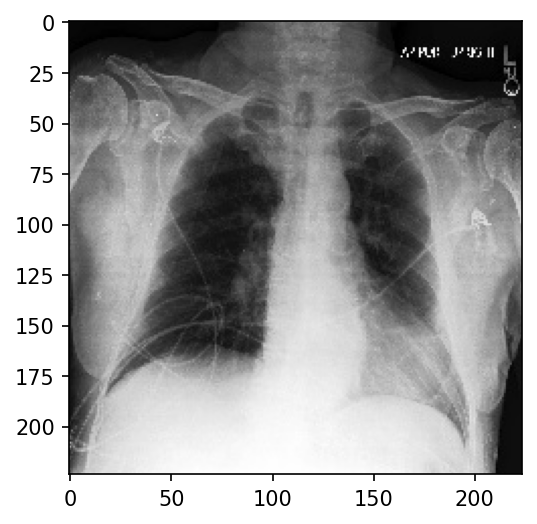

In [ ]:
#ploting the image with the original size
image_sample_name = '/content/sample_data/CheXpert/images/valid/patient64541/study1/view1_frontal.jpg'
plt.figure(dpi=150)
plt.imshow(skimage.io.imread(image_sample_name),cmap='gray')

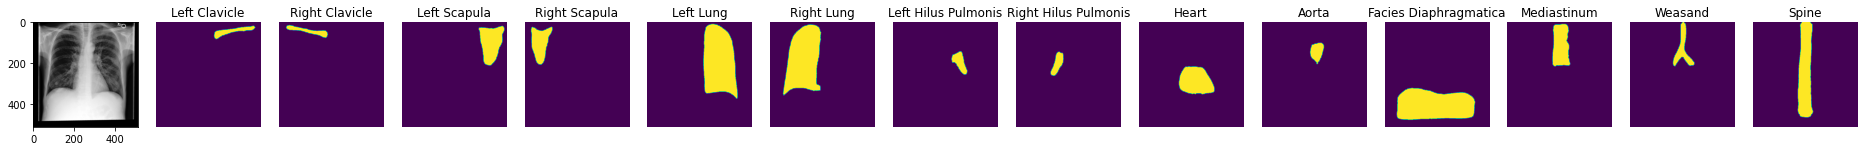

In [ ]:

# plotting all filters + processed image
plt.figure(figsize=(26, 5))
plt.subplot(1, 14 + 1, 1)
plt.imshow(image[0,:,:], cmap='gray')
for i in range(len(segment_names)):
    plt.subplot(1, len(segment_names) + 1, i + 2)
    plt.imshow(filters[0, i,:,:])
    plt.title(segment_names[i])
    plt.axis('off')
plt.tight_layout()

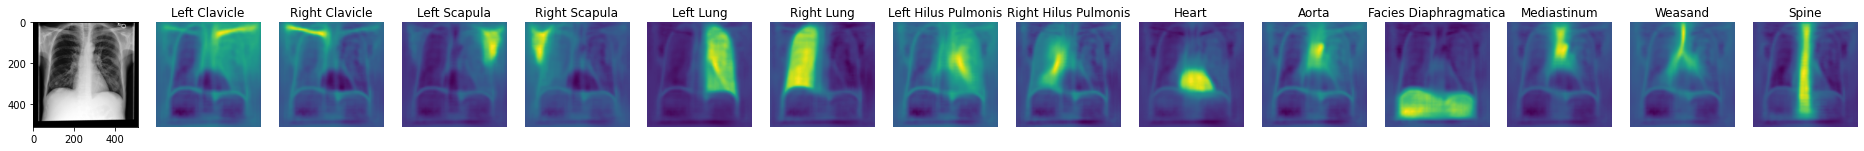

In [ ]:
# plotting all segments
plt.figure(figsize=(26, 5))
plt.subplot(1, 14 + 1, 1)
plt.imshow(image[0,:,:], cmap='gray')
for i in range(len(segment_names)):
    plt.subplot(1, len(segment_names) + 1, i + 2)
    plt.imshow(my_segments[0, i,:,:])
    plt.title(segment_names[i])
    plt.axis('off')
plt.tight_layout()

In [ ]:
# transfering the label file
s3.download_file(Bucket=Bucket,Filename='train.csv',Key='CheXpert/CheXpert-small/train.csv')

In [ ]:
train = pd.read_csv('train.csv')
train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
